In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
from scipy.stats import norm
import pandas_market_calendars as mcal

## Pre

#### Binomial tree class

In [37]:
class Binomial_Tree():
    """
    BinÇary_tree class.
    Inputs:
        -   S: stock price
        -   r: risk-free interest rate
        -   vol: volatility % in decimals
        -   T: Time period
        -   N: Number of steps/intervals
        -   auto: Compute tree automatically, True as default
    """

    def __init__(self,S,r,vol,T,N, K,auto = True):
        
        self.S = S
        self.r = r
        self.vol = vol
        self.T = T
        self.N = N
        self.dt = T/N
        
        if auto == True:
            self.build_tree()
            self.valueOptionMatrix(K)

    def build_tree(self):
    
        matrix = np.zeros((self.N+1,self.N+1))
        
        u = np.exp(self.vol*np.sqrt(self.dt))
        d = np.exp(-self.vol*np.sqrt(self.dt))
        matrix[0,0] = self.S
        
        
        for i in np.arange(self.N+1) :
            for j in np.arange(i+1) : 

                matrix[i,j] = self.S*(u**(j))*(d**(i-j))
        
        self.tree = matrix

    def valueOptionMatrix(self,K):

        self.K = K

        columns = self.tree.shape[1]
        rows = self.tree.shape[0]
        v_tree_european_put = np.copy(self.tree)
        v_tree_american_put = np.copy(self.tree)

        u= np.exp(self.vol*np.sqrt(self.dt))

        d= np.exp(-self.vol*np.sqrt(self.dt))

        p= (np.exp(self.r*self.dt) - d)/(u-d)   

        for c in np.arange(columns):
            St = self.tree[rows - 1, c] 
            v_tree_european_put[rows -1,c] = max(0., self.K - St)
            v_tree_american_put[rows -1,c] = max(0., self.K - St)

        for i in np.arange(rows - 1)[:: -1]:
            for j in np.arange(i + 1):

                european_down_put = v_tree_european_put[ i + 1, j ]
                european_up_put = v_tree_european_put[ i + 1, j + 1]

                american_down_put = v_tree_american_put[i + 1, j ]
                american_up_put = v_tree_american_put[i + 1, j +1]

                

                v_tree_european_put[i , j ] = max(np.exp(-self.r*self.dt)*(p*european_up_put + (1-p)*european_down_put),self.K - self.tree[i,j])
                

                v_tree_american_put[i,j] = max(np.exp(-self.r*self.dt)*(p*american_up_put + (1-p)*american_down_put), self.K - self.tree[i,j])
       
        self.v_tree_european_put = v_tree_european_put
        self.v_tree_american_put = v_tree_american_put

        


#### Bs class

In [38]:
def black_scholes(S,r,vol, T, K):
    """
    Black_scholes model option value.
    Inputs:
        -   S: stock price
        -   r: risk-free interest rate
        -   vol: volatility fo the stock % in decimals
        -   T: Time period
        -   K: Strike price

    """

    d1 = (np.log(S/K) + (r + 0.5*(vol**2)*T))/(vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    Vt = K * np.exp(-r * T) * norm.cdf(-d2) - S*norm.cdf(-d1)

    return Vt

#### Obtain Parameters for Option Pricing

In [20]:
aapl = yf.Ticker("AAPL")
n_years = 1
# get historical data for AAPL stock for n years
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*n_years)
aapl_data = yf.download('AAPL', start=start_date, end=end_date, progress=False)
option_expiry = '2024-09-20'

aapl_options = aapl.option_chain(option_expiry)
aapl_options.puts['ExpirationDate'] = option_expiry
puts_df = aapl_options.puts.copy(deep=True)
puts_df.to_csv('AAPL_puts.csv')
puts_df = puts_df[puts_df['inTheMoney'] == True]
puts_df.sort_values('strike', inplace=True)
puts_df.reset_index(drop=True, inplace=True)

print(f'Last Traded Price of put option with Expiry: {puts_df.loc[0,"ExpirationDate"]}, Strike price: ${puts_df.loc[0,"strike"]}, and Open Interest: {puts_df.loc[0,"openInterest"]} is ${puts_df.loc[0,"lastPrice"]}')
K = puts_df.loc[0,"strike"]
S = aapl_data['Close'].iloc[-1]

Last Traded Price of put option with Expiry: 2024-09-20, Strike price: $175.0, and Open Interest: 30243 is $11.28


## Question 1

#### (a) Time to expiration

In [21]:

nasdaq = mcal.get_calendar('NASDAQ')
n_trading_days = len(nasdaq.schedule(start_date=dt.datetime.now(), end_date=option_expiry))
T = round(n_trading_days/252,2)
print(f"Time to expiry in years: {T}")


Time to expiry in years: 0.53


#### (b) Risk free rate

In [22]:
R = 5.12 # 26 week US Treasury Bill rate
r = round(np.log(1 + R / 100),2)
print(f"Risk free rate: {r}")

Risk free rate: 0.05


#### (c) Annualized historical volatility

In [23]:
if n_years > 1:
    aapl_data['Log Returns'] = np.log(aapl_data['Adj Close'] / aapl_data['Adj Close'].shift(1))
else:
    aapl_data['Log Returns'] = np.log(aapl_data['Close'] / aapl_data['Close'].shift(1))

aapl_data['Log Returns'].dropna(inplace=True)
sigma = round(aapl_data['Log Returns'].std() * np.sqrt(252),2)
aapl_data.to_csv('AAPL_historical_data.csv')
print(f"Volatility: {sigma}")
vol = sigma

Volatility: 0.19


## Question 2

In [41]:
def question_2(S,r,vol,T,Ns,K, option = 'European'):
    binomial_trees = np.vectorize(Binomial_Tree,excluded= ['S','r','vol','T', 'K'])(S,r,vol,T,Ns,K)
    bs= black_scholes(S,r,vol, T, K)
    
    if option == 'European':
        values = np.vectorize(lambda x: x.v_tree_european_put[0,0])(binomial_trees)
    else:
        values = np.vectorize(lambda x: x.v_tree_american_put[0,0])(binomial_trees)
    return values,bs

aa


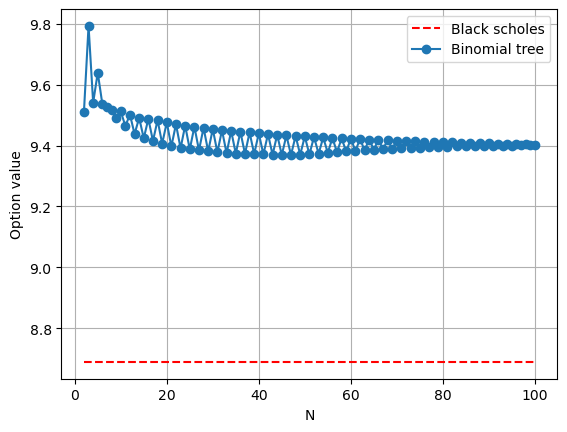

In [42]:
Ns = np.linspace(2,100, num = 99, dtype = int)
values, bs = question_2(S,r,vol,T,Ns,K)
plt.plot(Ns,np.full(len(Ns),bs), linestyle='--' ,label = "Black scholes", color = 'red')
plt.plot(Ns, values, marker = 'o' ,label = "Binomial tree")
plt.xlabel('N')
plt.ylabel('Option value')
plt.grid(True)
plt.legend()

## Question 3

In [36]:
binomial_tree = Binomial_Tree(S,r,vol,T,3,K)
print('European Put option')
print(binomial_tree.v_tree_european_put)

print('American Put option')
print(binomial_tree.v_tree_american_put)

European Put option
[[ 9.46688019  0.          0.          0.        ]
 [16.52823209  3.49950606  0.          0.        ]
 [27.13683742  7.601361    0.          0.        ]
 [39.90692571 16.5110984   0.          0.        ]]
American Put option
[[ 9.79307476  0.          0.          0.        ]
 [17.23676714  3.49950606  0.          0.        ]
 [28.67586338  7.601361    0.          0.        ]
 [39.90692571 16.5110984   0.          0.        ]]


### a)

The american option is worth more

In [13]:
### Optimal execution
np.where(binomial_tree.v_tree_american_put >binomial_tree.v_tree_american_put[0,0])

NameError: name 'binomial_tree' is not defined

### b)

In [ ]:
Ns = np.linspace(2,100, num = 99, dtype = int)
values, bs = question_2(S,r,vol,T,Ns,K, option= 'American')
plt.plot(Ns, values, marker = 'o' label = "Binomial tree")
plt.xlabel('N')
plt.ylabel('Option value')
plt.grid(True)
plt.legend()

### c)

In [ ]:
rs = np.linspace(0,1,num=100)